# IMPORT

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from deepmeg.preprocessing.transforms import one_hot_encoder, one_hot_decoder, zscore
from deepmeg.data.datasets import EpochsDataset
import math
from deepmeg.training.callbacks import Callback, EarlyStopping, L2Reg, PrintingCallback
from deepmeg.models import BaseModel
from deepmeg.utils.viz import plot_metrics
import pandas as pd
from sklearn.metrics import confusion_matrix
from utils.viz import plot_distribution
from deepmeg.preprocessing.transforms import one_hot_decoder



def accuracy(predictions: torch.Tensor, targets: torch.Tensor) -> float:
    """
    Calculate the accuracy of predictions.

    Args:
        predictions (torch.Tensor): The predicted scores from the model.
        targets (torch.Tensor): The true target labels.

    Returns:
        float: The accuracy of the predictions.
    """
    # Convert one-hot encoded labels to class indices
    targets = torch.argmax(targets, dim=1)

    # Compute predicted class indices
    _, predicted = torch.max(predictions, dim=1)

    # Compute accuracy
    correct = torch.sum(predicted == targets)
    total = targets.shape[0]
    accuracy = correct / total

    return accuracy


def compute_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, labels: list[int | str] = None):
    """
    Compute a confusion matrix and return it as a pandas DataFrame.

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        labels (list, optional): List of labels to include in the confusion matrix.
                                If None, all unique labels present in y_true and y_pred will be used.

    Returns:
        pd.DataFrame: Confusion matrix as a DataFrame.
    """
    conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)

    if labels is None:
        labels = sorted(set(np.concatenate([y_true, y_pred], axis=0)))

    conf_matrix_df = pd.DataFrame(conf_matrix, index=labels, columns=labels)

    return conf_matrix_df


def plot_confusion_matrix(confusion_matrix_df: pd.DataFrame, title: str = "Confusion Matrix Heatmap", cbar: bool = False) -> plt.Figure:
    """
    Visualize a confusion matrix stored in a pandas DataFrame using a heatmap.

    Args:
        confusion_matrix_df (pd.DataFrame): Confusion matrix as a DataFrame.
        title (str, optional): Title for the plot. Defaults to "Confusion Matrix Heatmap".
        cbar (bool, optional): Whether to show a colorbar. Defaults to False.

    Returns:
        plt.Figure: Matplotlib Figure object containing the confusion matrix plot.
    """
    fig, ax = plt.subplots(figsize=(10, 7))
    im = ax.imshow(confusion_matrix_df, interpolation="nearest", cmap=plt.cm.Blues)
    ax.set_title(title)
    if cbar:
        cbar = ax.figure.colorbar(im, ax=ax)
    tick_marks = range(len(confusion_matrix_df.columns))

    if any([not isinstance(column, (int, float)) and len(column) > 5 for column in confusion_matrix_df.columns]):
        ax.set_xticks(tick_marks)
        ax.set_xticklabels(confusion_matrix_df.columns, rotation=45)
    else:
        ax.set_xticks(tick_marks)
        ax.set_xticklabels(confusion_matrix_df.columns)

    ax.set_yticks(tick_marks)
    ax.set_yticklabels(confusion_matrix_df.index)

    for i in range(len(confusion_matrix_df.index)):
        for j in range(len(confusion_matrix_df.columns)):
            cell_value = confusion_matrix_df.iloc[i, j]
            text_color = "#eee" if cell_value > confusion_matrix_df.max().max() / 2 else "#333"
            ax.text(j, i, str(cell_value), ha="center", va="center", color=text_color)

    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")
    fig.tight_layout()

    return fig


# Encoder-Decoder LSTM with Bahdanau Attention

In [2]:
class BahdanauAttention(nn.Module):
    def __init__(self, encoder_hidden_size: int, decoder_hidden_size: int, attention_size: int, bias: bool = True):
        """
        Bahdanau Attention Mechanism.

        Args:
            encoder_hidden_size (int): The size of the encoder hidden states.
            decoder_hidden_size (int): The size of the decoder hidden states.
            attention_size (int): The size of the attention vector.
        """
        super(BahdanauAttention, self).__init__()
        self.encoder_hidden_size = encoder_hidden_size
        self.decoder_hidden_size = decoder_hidden_size
        self.attention_size = attention_size

        self.W_enc = nn.Linear(encoder_hidden_size, attention_size)
        self.W_dec = nn.Linear(decoder_hidden_size, attention_size)
        self.V = nn.Linear(attention_size, 1)

        if bias:
            self.bias = nn.Parameter(torch.empty(attention_size))
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.W_dec.weight)
            if fan_in != 0:
                bound = 1 / math.sqrt(fan_in)
                nn.init.uniform_(self.bias, -bound, bound)
        else:
            self.register_parameter('bias', None)

    def forward(self, encoder_hidden_states: torch.Tensor, decoder_hidden_state: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Perform the forward pass of the Bahdanau Attention Mechanism.

        Args:
            encoder_hidden_states (torch.Tensor): The encoder hidden states. Shape: (batch_size, seq_length, encoder_hidden_size)
            decoder_hidden_state (torch.Tensor): The current decoder hidden state. Shape: (batch_size, decoder_hidden_size)

        Returns:
            context_vector (torch.Tensor): The context vector for the current decoder step. Shape: (batch_size, encoder_hidden_size)
            attention_weights (torch.Tensor): The attention weights over the encoder hidden states. Shape: (batch_size, seq_length)
        """
        seq_length = encoder_hidden_states.size(1)

        # Calculate alignment scores
        encoder_score = self.W_enc(encoder_hidden_states)  # (batch_size, seq_length, attention_size)

        decoder_score = self.W_dec(decoder_hidden_state)  # (batch_size, 1, attention_size)

        # Combine encoder and decoder scores and apply the non-linearity
        b = self.bias if self.bias is not None else 0
        alignment_scores = torch.tanh(encoder_score + torch.unsqueeze(decoder_score, 1) + b)  # (batch_size, seq_length, attention_size)

        # Calculate attention weights
        attention_weights = self.V(alignment_scores).squeeze(-1)  # (batch_size, seq_length)

        # Apply softmax to get normalized attention weights
        attention_weights = torch.softmax(attention_weights, dim=-1)  # (batch_size, seq_length)

        # Calculate context vector as a weighted sum of encoder hidden states
        context_vector = torch.bmm(attention_weights.unsqueeze(1), encoder_hidden_states.view(-1, seq_length, self.encoder_hidden_size))
        context_vector = context_vector.squeeze(1)  # (batch_size, encoder_hidden_size)

        return context_vector, attention_weights


class EncoderDecoderLSTM(nn.Module):
    def __init__(self, input_size: int, encoder_hidden_size: int, decoder_hidden_size: int, attention_size: int):
        """
        Encoder-Decoder LSTM with Bahdanau Attention.

        Args:
            input_size (int): The size of the input features.
            encoder_hidden_size (int): The size of the encoder hidden states.
            decoder_hidden_size (int): The size of the decoder hidden states.
            attention_size (int): The size of the attention vector.
        """
        super(EncoderDecoderLSTM, self).__init__()
        self.encoder_hidden_size = encoder_hidden_size
        self.decoder_hidden_size = decoder_hidden_size
        self.attention_size = attention_size

        self.encoder_lstm = nn.LSTM(input_size, encoder_hidden_size, batch_first=True)
        self.attention = BahdanauAttention(encoder_hidden_size, decoder_hidden_size, attention_size)

        self.decoder_lstm = nn.LSTMCell(decoder_hidden_size + encoder_hidden_size, decoder_hidden_size)
        self._attention_weights = None

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Perform the forward pass of the Encoder-Decoder LSTM.

        Args:
            x (torch.Tensor): The input tensor. Shape: (n_batch, n_times, n_features)

        Returns:
            output (torch.Tensor): The output tensor. Shape: (n_batch, n_times, decoder_hidden_size)
        """
        n_batch, n_times, n_features = x.size()

        # Encoder LSTM
        encoder_hidden_states, (h_n_enc, c_n_enc) = self.encoder_lstm(x)

        # Decoder LSTM initial hidden state
        h_n_dec, c_n_dec = self.decoder_lstm(torch.zeros(n_batch, self.decoder_hidden_size + self.encoder_hidden_size).to(x.device))

        # Output tensor to store predictions
        output = torch.zeros(n_batch, n_times, self.decoder_hidden_size).to(x.device)
        attention_weights = list()

        # Iterate over each time step
        for t in range(n_times):

            context_vector, current_attention_weights = self.attention(encoder_hidden_states, h_n_dec)

            attention_weights.append(current_attention_weights)

            # Concatenate the context vector with the current decoder hidden state
            decoder_input = torch.cat((context_vector, h_n_dec), dim=-1)

            # Update the decoder LSTM hidden state at the current time step
            h_n_dec, c_n_dec = self.decoder_lstm(decoder_input, (h_n_dec, c_n_dec))

            # Compute output at the current time step
            output[:, t, :] = h_n_dec

        self._attention_weights = attention_weights
        return output
        # return encoder_hidden_states

    @property
    def attention_weights(self):
        return self._attention_weights


## DATA

In [793]:
kind = 'arousal'
subject = 0
dataset = EpochsDataset.load(f'../data/{kind}_{subject}.pt')
train, test = torch.utils.data.random_split(dataset, [.7, .3])

In [754]:
kind = 'valence'
dataset1 = EpochsDataset.load(f'../data/{kind}_1.pt')
# dataset2 = EpochsDataset.load(f'../data/{kind}_10.pt')
# dataset3 = EpochsDataset.load(f'../data/{kind}_101.pt')
dataset4 = EpochsDataset.load(f'../data/{kind}_0.pt')
dataset = torch.utils.data.ConcatDataset([
    dataset1,
    # dataset2,
    # dataset3,
    dataset4
])
train, test = torch.utils.data.random_split(dataset, [.7, .3])

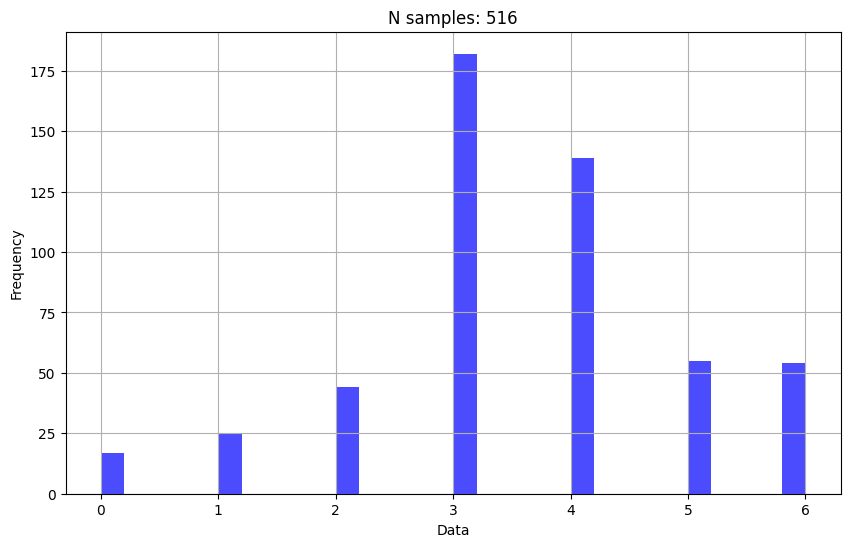

In [755]:
X, Y = next(iter(DataLoader(dataset, len(dataset))))

fig = plot_distribution(one_hot_decoder(Y), title=f'N samples: {len(dataset)}')

In [796]:
X = np.load('/home/user/Downloads/X_balanced_valence_time_clean.npy')

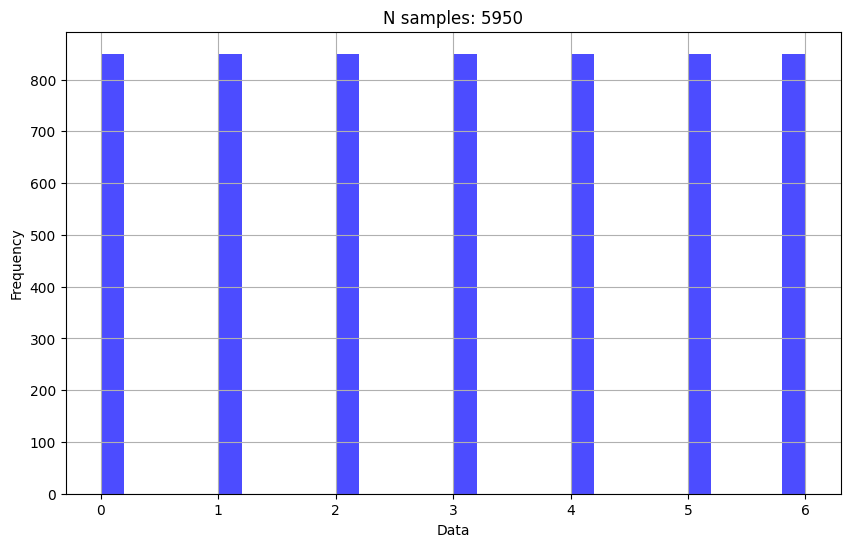

In [812]:
Y = np.load('/home/user/Downloads/y_balanced_valence_clean.npy')
X = np.squeeze(np.load('/home/user/Downloads/X_balanced_valence_time_clean.npy'))
dataset = EpochsDataset((X, Y), savepath='../datasets/valence_all')
train, test = torch.utils.data.random_split(dataset, [.7, .3])
fig = plot_distribution(one_hot_decoder(Y), title=f'N samples: {len(dataset)}')

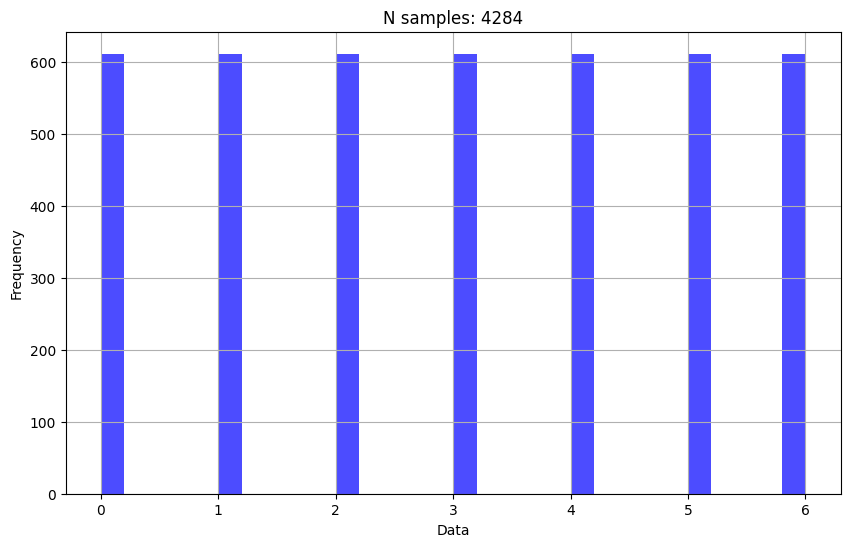

In [5]:
Y = np.load('/home/user/Downloads/y_balanced_arousal_clean.npy')
X = np.squeeze(np.load('/home/user/Downloads/X_balanced_arousal_time_clean.npy'))
dataset = EpochsDataset((X, Y), savepath='../datasets/valence_all')
train, test = torch.utils.data.random_split(dataset, [.7, .3])
fig = plot_distribution(one_hot_decoder(Y), title=f'N samples: {len(dataset)}')

In [6]:
X, Y = next(iter(DataLoader(train, 1)))

In [7]:
X.shape, (X.min(), X.mean(), X.std(), X.max()), Y.shape, Y, torch.argmax(Y)

(torch.Size([1, 300, 5]),
 (tensor(-3.2018), tensor(-0.4701), tensor(0.8945), tensor(1.7951)),
 torch.Size([1, 7]),
 tensor([[0., 0., 0., 0., 0., 0., 1.]]),
 tensor(6))

In [861]:
len(train), len(test)

(2999, 1285)

## Model

In [16]:
class TinyNet(BaseModel):

    def __init__(
        self,
        input_size: int,
        encoder_hidden_size: int,
        decoder_hidden_size: int,
        attention_size: int,
        n_times: int,
        n_outputs: int
    ):
        super().__init__()
        self.linear = nn.Linear(n_times, n_times//10)
        self.attn_net = EncoderDecoderLSTM(
            input_size=input_size,
            encoder_hidden_size=encoder_hidden_size,
            decoder_hidden_size=decoder_hidden_size,
            attention_size=attention_size
        )
        self.fc_layer = nn.Linear(decoder_hidden_size*n_times//10, n_outputs)
        # self.fc_layer = nn.Linear(decoder_hidden_size*n_times, n_outputs)


    def forward(self, x: torch.Tensor):
        x = torch.permute(x, (0, 2, 1))
        x = self.linear(x)
        x = torch.permute(x, (0, 2, 1))
        x = self.attn_net(x)
        x = torch.flatten(x, 1)
        return self.fc_layer(x)


In [17]:
X.shape, Y.shape

(torch.Size([1, 300, 5]), torch.Size([1, 7]))

In [18]:
config = dict(
    input_size=X.shape[-1],
    encoder_hidden_size=3,
    decoder_hidden_size=3,
    attention_size=3,
    n_times=X.shape[1],
    n_outputs=Y.shape[-1]
)

In [19]:
Y.shape[-1]

7

In [20]:
model = TinyNet(
    **config
)

optimizer = torch.optim.AdamW

# loss = torch.nn.BCEWithLogitsLoss()
loss = torch.nn.CrossEntropyLoss()
    # weight=torch.tensor([
    #     1., # 0
    #     1., # 1
    #     1., # 2
    #     .5, # 3
    #     .5, # 4
    #     1., # 5
    #     1., # 6
    # ])
# )

metric = accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(),
        EarlyStopping(monitor='loss_train', patience=30, restore_best_weights=False),
        # L2Reg(
        #     ['linear.weight', 'attn_net.encoder_lstm.weight_hh_l0'],
        #     .001,
        # )
    ]
)

In [21]:
dict(model.named_parameters()).keys()

dict_keys(['attn_net.encoder_lstm.weight_ih_l0', 'attn_net.encoder_lstm.weight_hh_l0', 'attn_net.encoder_lstm.bias_ih_l0', 'attn_net.encoder_lstm.bias_hh_l0', 'attn_net.attention.bias', 'attn_net.attention.W_enc.weight', 'attn_net.attention.W_enc.bias', 'attn_net.attention.W_dec.weight', 'attn_net.attention.W_dec.bias', 'attn_net.attention.V.weight', 'attn_net.attention.V.bias', 'attn_net.decoder_lstm.weight_ih', 'attn_net.decoder_lstm.weight_hh', 'attn_net.decoder_lstm.bias_ih', 'attn_net.decoder_lstm.bias_hh', 'fc_layer.weight', 'fc_layer.bias'])

In [22]:
import sys

if hasattr(sys.stdout, 'file'):
  sys.stdout = sys.stdout.file

Epoch 0:  loss_train:  1.9531   |    accuracy_train:  0.1450   |    loss_val:  1.9604   |    accuracy_val:  0.1291
Epoch 1:  loss_train:  1.9465   |    accuracy_train:  0.1520   |    loss_val:  1.9500   |    accuracy_val:  0.1291
Epoch 2:  loss_train:  1.9447   |    accuracy_train:  0.1475   |    loss_val:  1.9459   |    accuracy_val:  0.1532
Epoch 3:  loss_train:  1.9424   |    accuracy_train:  0.1585   |    loss_val:  1.9484   |    accuracy_val:  0.1402
Epoch 4:  loss_train:  1.9398   |    accuracy_train:  0.1650   |    loss_val:  1.9487   |    accuracy_val:  0.1481
Epoch 5:  loss_train:  1.9381   |    accuracy_train:  0.1590   |    loss_val:  1.9460   |    accuracy_val:  0.1441
Epoch 6:  loss_train:  1.9363   |    accuracy_train:  0.1620   |    loss_val:  1.9442   |    accuracy_val:  0.1712
Epoch 7:  loss_train:  1.9342   |    accuracy_train:  0.1655   |    loss_val:  1.9442   |    accuracy_val:  0.1682
Epoch 8:  loss_train:  1.9324   |    accuracy_train:  0.1735   |    loss_val:  1

[<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>]

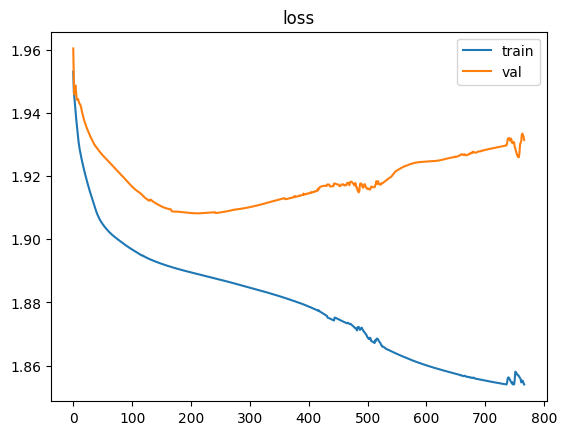

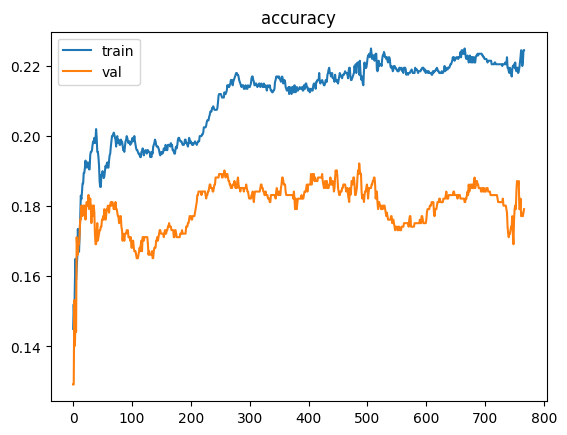

In [23]:
history = model.fit(train, n_epochs=1500, batch_size=400, val_batch_size=200)
plot_metrics(history)

In [24]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 1.8607093746011907
train_accuracy: 0.22951927645639938
loss: 1.9274092695929788
accuracy: 0.19829545508731494


In [ ]:
X_test, Y_test = next(iter(DataLoader(test, len(test))))
print(set(one_hot_decoder(Y_test)))


Preds_test = model(X_test)

sources = torch.permute(X_test, (0, 2, 1))
sources = model.linear(sources)
sources = torch.permute(sources, (0, 2, 1))

Text(0.5, 1.0, 'sample 774, class 4, pred 5')

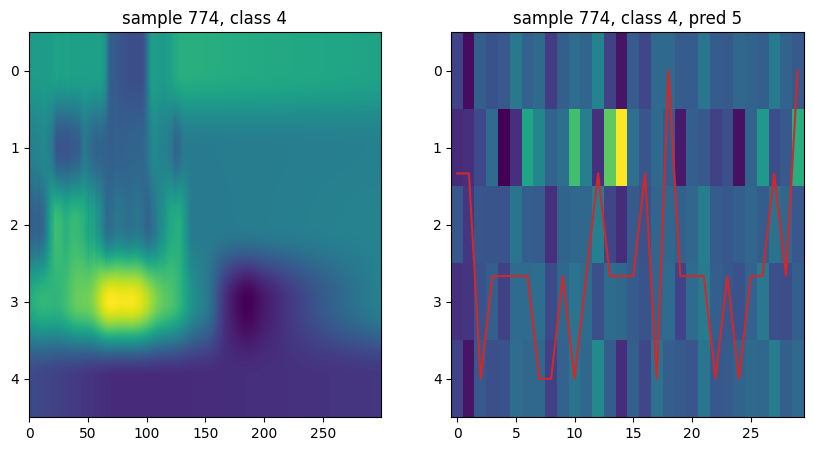

In [ ]:
n = np.random.randint(0, len(test))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
attn_w = torch.stack(model.attn_net.attention_weights)[:, n].detach().numpy()
ax1.imshow(X_test[n].T, aspect='auto')
label = np.argmax(Y_test[n]).item()
ax1.set_title(f'sample {n}, class {label}')
# ax1.imshow(attn_w, zorder=1)
ax2.imshow(sources.detach().numpy().mean(0).T, zorder=1, aspect='auto')
attn_tc = attn_w.mean(1)
ax2.plot((attn_tc - attn_tc.min())/(attn_tc.max() - attn_tc.min())*(sources.shape[-1] - 1), zorder=2, color='tab:red')
ax2.set_title(f'sample {n}, class {label}, pred {np.argmax(Preds_test[n].detach())}')

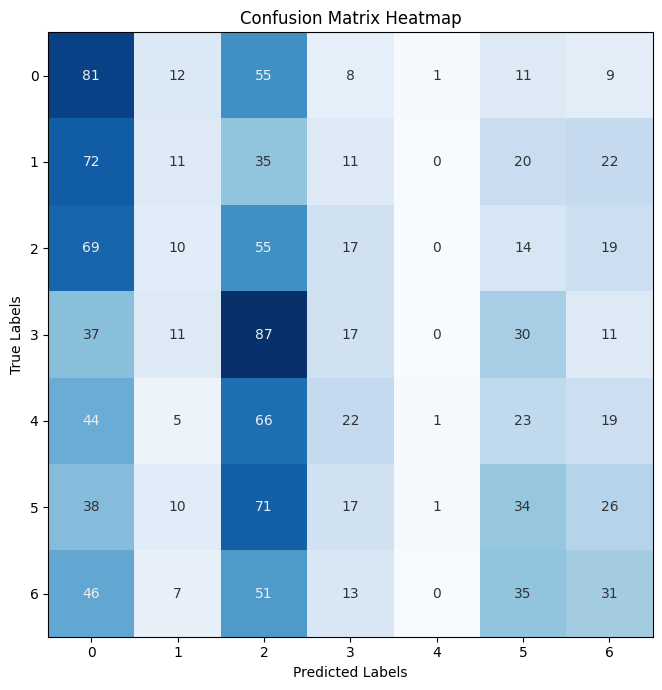

In [26]:
conf_matrix_data = compute_confusion_matrix(
    one_hot_decoder(Y_test), one_hot_decoder(Preds_test)
)

confusion_matrix_df = pd.DataFrame(
    conf_matrix_data,
    index = conf_matrix_data.keys(),
    columns = conf_matrix_data.keys()
)

# Visualize the confusion matrix with color-coded text
fig = plot_confusion_matrix(confusion_matrix_df)
